# GNN for Link + Vote Prediction with sliding window training

This notebook trains a **Hierarchical Graph Neural Network** to predict link existance and vote polarity simultaneously.

In this variant we explore the **sliding window training approach**, which consists in:

- firstly consider a window of fixed size W
- split the window in training, validation and test sets and perform training and evaluation
- then move the window by a step size S
- this approach until now **do not** use the concept of continual learning


## Setup

In [1]:
# Import standard libraries
import sys, random
from pathlib import Path
from collections import defaultdict, Counter
# Plotting
import seaborn as sns
import matplotlib.pyplot as plt
# Data handling
import pandas as pd
# Computations
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import SAGEConv
from torch_geometric.loader import LinkNeighborLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score
# Import this project modules
REPO_ROOT = Path('.').resolve()
if REPO_ROOT not in sys.path:
    sys.path.insert(0, str(REPO_ROOT))
from dataset import WikiRfAPreprocessor, CandidateCentricSampler

## Data loading and filtering

Load and parse the wiki-RfA dataset from the .txt.gz file into (SRC, TGT, VOT, DAT) tuples.

Invalid samples are filtered out:

- empty date
- incorrect date
- self votes

In [2]:
preprocessed_RfA = WikiRfAPreprocessor("dataset/wiki-RfA.txt.gz")
preprocessed_RfA.load(verbose=True)

Loading dataset from dataset/wiki-RfA.txt.gz...
Raw line 0: SRC:Steel1943
Raw line 1: TGT:BDD
Raw line 2: VOT:1
Raw line 3: RES:1
Raw line 4: YEA:2013
Raw line 5: DAT:23:13, 19 April 2013
Raw line 6: TXT:'''Support''' as co-nom.
Raw line 7: 
Raw line 8: SRC:Cuchullain
Raw line 9: TGT:BDD

------- Dataset Loaded -------
Total valid samples loaded: 188816
Example sample (SRC, TGT, VOT, DATE): ('Steel1943', 'BDD', 1, 20130419)

Discarded edges breakdown:
  EMPTY_ERROR: 9367
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Jason Quinn', '')
    Skipped edge: ('', 'Legoktm', '')
    Skipped edge: ('Majoreditor', 'Lord Roem', '')
  SELF_LOOP: 88
    Skipped edge: ('Ryan Vesey', 'Ryan Vesey', '17:07, 4 July 2012')
    Skipped edge: ('Anomie', 'Anomie', '16:29, 25 September 2011')
    Skipped edge: ('Spongefrog', 'Spongefrog', '18:33, 28 September 2011')
    Skipped edge: ('Tarheel95', 'Tarheel95', '00:46, 8 December 2011')
  ERROR_OTHERS: 4
    Skipped edge: ('JonasEncycloped

## User encoding

Encode Wikipedia usernames into contiguous integer node IDs.

In [3]:
# Encode users as numerical IDs
users = list(set([s[0] for s in preprocessed_RfA.samples] + [s[1] for s in preprocessed_RfA.samples]))
encoder = LabelEncoder()
user_ids = encoder.fit_transform(users)
user_map = dict(zip(users, user_ids))

print(f"Unique users: {len(users)}")
print(list(user_map.items())[:10])

Unique users: 11128
[('ConnorJack', np.int64(2042)), ('Snakenath', np.int64(8841)), ('Lbmixpro', np.int64(5583)), ('Soxwon', np.int64(8939)), ('Lord Emsworth', np.int64(5748)), ('%D0%90', np.int64(1)), ('Zeldatime', np.int64(10755)), ('VD64992', np.int64(10059)), ('Arch NME', np.int64(723)), ('Hurricane111', np.int64(4322))]


In [4]:
# Dataset build (edge list + label)
X = []
y = []
dates = []

for src, tgt, vot, dat in preprocessed_RfA.samples:
    X.append([user_map[src], user_map[tgt]])
    y.append(vot)
    dates.append(dat)
        
X = torch.tensor(X, dtype=torch.long)
y = torch.tensor(y, dtype=torch.long)
dates = np.array(dates)

# labels for positives: {-1,0,1} -> {1,2,3}
y_pos = y + 2
print("Positive edges:", X.size(0))

Positive edges: 188816


## Generate windows

In [5]:
def sum_months(date1, months2):
    """Utility function to sum months to a date in YYYYMMDD format."""
    temp1, days1 = divmod(date1, 100)
    year1, month1 = divmod(temp1, 100)

    total_months = month1 + months2
    new_year, new_month = divmod(total_months, 12)
    if total_months % 12 == 0:
        new_year -= 1
        new_month = 12

    new_date = str(year1 + new_year) + (str(new_month).zfill(2)) + (str(days1).zfill(2))
    new_date = int(new_date)

    return new_date

print("Date sum example:", 20220306, "+", 1, "months =", sum_months(20220306, 1))


Date sum example: 20220306 + 1 months = 20220406


In [6]:
def get_windows(edges, labels, dates_int, window_size_months=36, step_size_months=6, valid_ratio=0.15, test_ratio=0.15):
    """
    Generatore che restituisce (X_train, y_train), (X_test, y_test) per ogni finestra.
    """
    current_start = min(dates_int)
    
    while True:
        current_end = sum_months(current_start, window_size_months)
        
        # Se la finestra supera la data massima del dataset, ci fermiamo
        if current_end > max(dates_int):
            print("Reached the end of the date range. Discarded window:", current_start, "->", current_end)
            break
        
        # 1. Selezioniamo gli indici che cadono nella finestra corrente [start, end]
        mask_window = (dates_int >= current_start) & (dates_int < current_end)
        indices_window = np.where(mask_window)[0]
        
        # If the window is empty, skip it
        if len(indices_window) == 0:
            current_start += step_size_months
            continue

        # 2. Split temporale INTERNO alla finestra
        # Ordiniamo gli indici di questa finestra per data
        window_dates = dates_int[indices_window]
        sorted_idx_local = np.argsort(window_dates)
        sorted_indices_global = indices_window[sorted_idx_local] # indices of dates_int such that dates_int[sorted_indices_global] is sorted
        
        split_point1 = int(len(sorted_indices_global) * (1 - valid_ratio - test_ratio))
        split_point2 = int(len(sorted_indices_global) * (1 - test_ratio))
        
        train_idx = sorted_indices_global[:split_point1]
        val_idx = sorted_indices_global[split_point1:split_point2]
        test_idx = sorted_indices_global[split_point2:]

        # Creiamo i tensori per questa finestra
        X_train = torch.tensor(edges[train_idx], dtype=torch.long)
        y_train = torch.tensor(labels[train_idx], dtype=torch.long)
        X_val = torch.tensor(edges[val_idx], dtype=torch.long)
        y_val = torch.tensor(labels[val_idx], dtype=torch.long)
        X_test = torch.tensor(edges[test_idx], dtype=torch.long)
        y_test = torch.tensor(labels[test_idx], dtype=torch.long)
        
        yield (X_train, y_train, dates[train_idx]), (X_val, y_val, dates[val_idx]), (X_test, y_test, dates[test_idx])
        
        # Avanzamento
        current_start = sum_months(current_start, step_size_months)

windows = get_windows(X.numpy(), y_pos.numpy(), dates)

Reached the end of the date range. Discarded window: 20100816 -> 20130816
    Total_Size        Train_Interval          Val_Interval         Test_Interval
0        52168  (20030816, 20060424)  (20060424, 20060615)  (20060615, 20060815)
1        71369  (20040216, 20060731)  (20060731, 20061109)  (20061109, 20070215)
2        88760  (20040816, 20061226)  (20061226, 20070416)  (20070416, 20070815)
3       106034  (20050216, 20070428)  (20070428, 20070925)  (20070925, 20080215)
4       117673  (20050816, 20070825)  (20070825, 20080130)  (20080130, 20080815)
5       110467  (20060216, 20071215)  (20071215, 20080530)  (20080530, 20090215)
6        96891  (20060816, 20080518)  (20080518, 20081215)  (20081215, 20090815)
7        87371  (20070216, 20081110)  (20081110, 20090612)  (20090612, 20100215)
8        74046  (20070816, 20090430)  (20090430, 20091107)  (20091107, 20100815)
9        60723  (20080216, 20091027)  (20091027, 20100614)  (20100614, 20110215)
10       49709  (20080816, 20100523

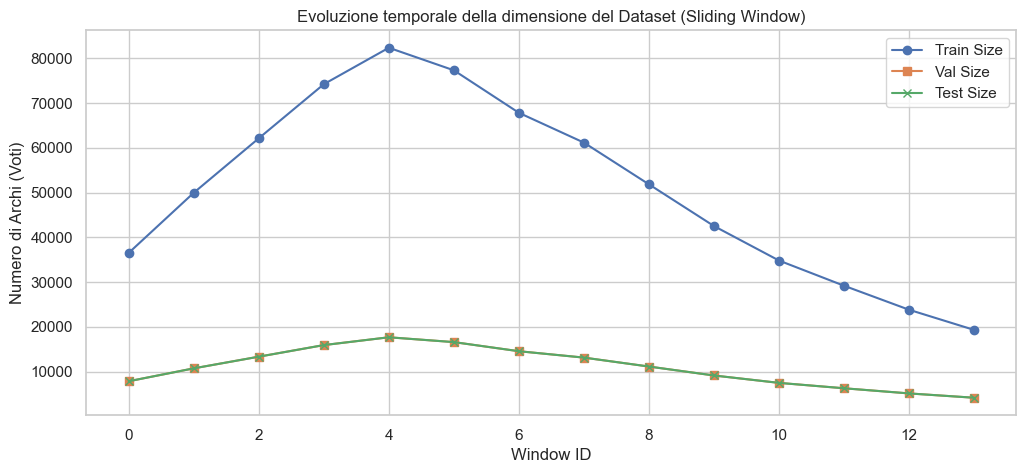

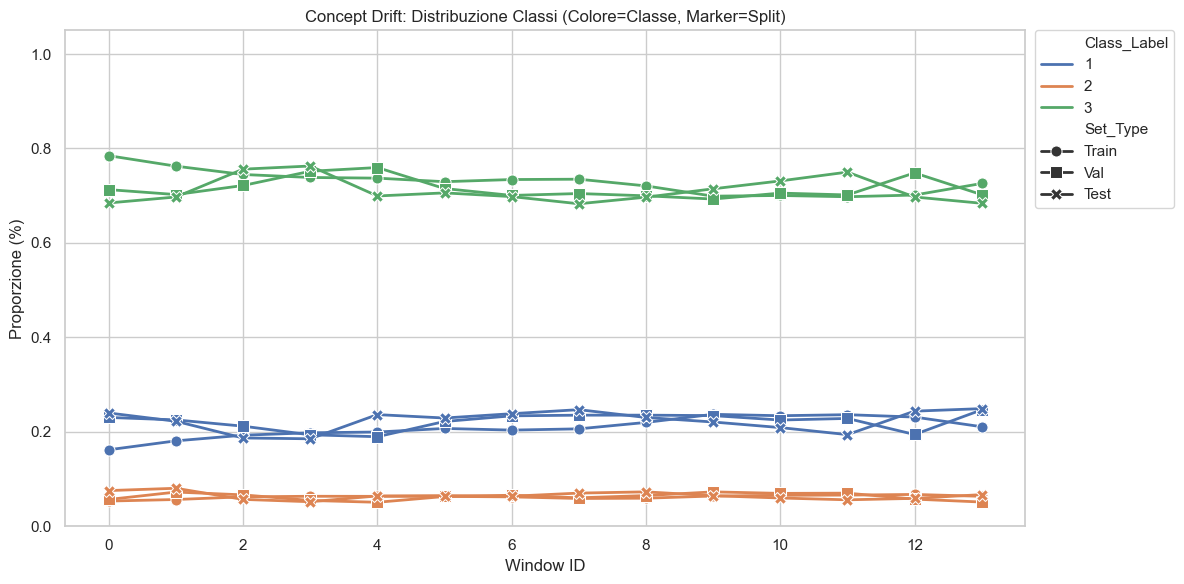

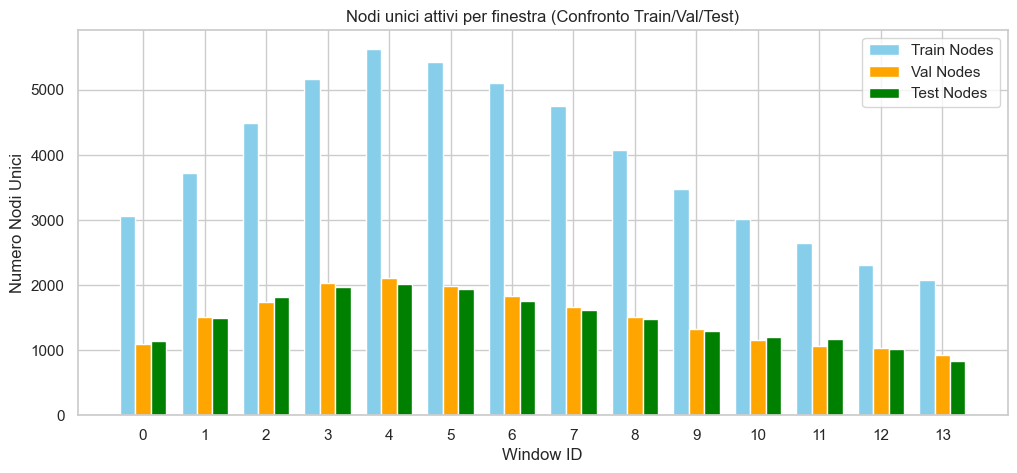

In [7]:
def analyze_sliding_windows(window_generator):
    """
    Consuma il generatore di finestre e calcola statistiche dettagliate.
    Args:
        window_generator: Il generatore restituito da get_windows()
    Returns:
        pd.DataFrame: DataFrame contenente le statistiche per ogni finestra.
    """
    stats_list = []
    
    for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(window_generator):
        
        # Calcolo distribuzioni delle classi
        train_counts = Counter(y_tr.numpy())
        val_counts = Counter(y_va.numpy())
        test_counts = Counter(y_te.numpy())
        
        # Calcolo nodi unici attivi (Voters + Candidates)
        train_unique_nodes = len(np.unique(X_tr.numpy()))
        val_unique_nodes = len(np.unique(X_va.numpy()))
        test_unique_nodes = len(np.unique(X_te.numpy()))
        
        # Struttura dati per il DataFrame
        row = {
            'Window_ID': i,
            'Train_Size': len(y_tr),
            'Val_Size': len(y_va),
            'Test_Size': len(y_te),
            'Total_Size': len(y_tr) + len(y_va) + len(y_te),
            'Train_Interval': (min(dates_tr), max(dates_tr)),
            'Val_Interval': (min(dates_va), max(dates_va)),
            'Test_Interval': (min(dates_te), max(dates_te)),
            'Train_Unique_Nodes': train_unique_nodes,
            'Val_Unique_Nodes': val_unique_nodes,
            'Test_Unique_Nodes': test_unique_nodes,
            'Train_Ratio': len(y_tr) / (len(y_tr) +len(y_va) + len(y_te)),
            'Val_Ratio': len(y_va) / (len(y_tr) + len(y_va) + len(y_te)),
            'Test_Ratio': len(y_te) / (len(y_tr) + len(y_va) + len(y_te))
        }
        
        # Aggiungiamo le info sulle classi in colonne separate (es. Train_Class_0, Train_Class_1...)
        all_classes = set(list(train_counts.keys()) + list(val_counts.keys()) + list(test_counts.keys()))
        for cls in sorted(all_classes):
            row[f'Train_Class_{cls}'] = train_counts.get(cls, 0)
            row[f'Val_Class_{cls}'] = val_counts.get(cls, 0)
            row[f'Test_Class_{cls}'] = test_counts.get(cls, 0)
            
            # Calcoliamo anche la percentuale per vedere il drift
            row[f'Train_Perc_Class_{cls}'] = train_counts.get(cls, 0) / len(y_tr) if len(y_tr) > 0 else 0
            row[f'Val_Perc_Class_{cls}'] = val_counts.get(cls, 0) / len(y_va) if len(y_va) > 0 else 0
            row[f'Test_Perc_Class_{cls}'] = test_counts.get(cls, 0) / len(y_te) if len(y_te) > 0 else 0
            
        stats_list.append(row)

    df_stats = pd.DataFrame(stats_list)
    return df_stats

def plot_window_stats(df_stats):
    sns.set_theme(style="whitegrid")
    
    # --- 1. Plot Dimensione dei Dataset nel tempo ---
    plt.figure(figsize=(12, 5))
    plt.plot(df_stats['Window_ID'], df_stats['Train_Size'], label='Train Size', marker='o')
    plt.plot(df_stats['Window_ID'], df_stats['Val_Size'], label='Val Size', marker='s')
    plt.plot(df_stats['Window_ID'], df_stats['Test_Size'], label='Test Size', marker='x')
    plt.title('Evoluzione temporale della dimensione del Dataset (Sliding Window)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero di Archi (Voti)')
    plt.legend()
    plt.show()
    
    # --- 2. Plot Distribuzione delle Classi (Concept Drift) ---
    perc_cols = [c for c in df_stats.columns if '_Perc_Class_' in c]
    
    if perc_cols:
        df_melted = df_stats.melt(id_vars='Window_ID', value_vars=perc_cols, 
                                  var_name='Variable', value_name='Percentage')
        
        # Funzione per estrarre Set e Classe dal nome della colonna
        def parse_col_name(name):
            parts = name.split('_Perc_Class_')
            return parts[0], parts[1]

        df_melted[['Set_Type', 'Class_Label']] = df_melted['Variable'].apply(
            lambda x: pd.Series(parse_col_name(x))
        )
        
        plt.figure(figsize=(12, 6))
        
        markers_map = {"Train": "o", "Val": "s", "Test": "X"}
        linestyles_map = {"Train": "", "Val": "", "Test": ""}         
        sns.lineplot(
            data=df_melted, 
            x='Window_ID', 
            y='Percentage', 
            hue='Class_Label',    # Stesso colore per la stessa classe
            style='Set_Type',     # Diverso simbolo per Train/Val/Test
            markers=markers_map,  # Mappatura personalizzata dei simboli
            dashes=False,         # Forza linee solide per tutti (la distinzione è nel marker)
            linewidth=2,
            markersize=8
        )
        plt.title('Concept Drift: Distribuzione Classi (Colore=Classe, Marker=Split)')
        plt.xlabel('Window ID')
        plt.ylabel('Proporzione (%)')
        plt.ylim(0, 1.05)
        plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0.)
        plt.tight_layout()
        plt.show()
    
    # --- 3. Analisi Nodi Unici (Densità/Sparsità) ---
    plt.figure(figsize=(12, 5))
    bar_width = 0.25
    x = df_stats['Window_ID']
    plt.bar(x - bar_width, df_stats['Train_Unique_Nodes'], width=bar_width, label='Train Nodes', color='skyblue')
    plt.bar(x, df_stats['Val_Unique_Nodes'], width=bar_width, label='Val Nodes', color='orange')
    plt.bar(x + bar_width, df_stats['Test_Unique_Nodes'], width=bar_width, label='Test Nodes', color='green')
    plt.title('Nodi unici attivi per finestra (Confronto Train/Val/Test)')
    plt.xlabel('Window ID')
    plt.ylabel('Numero Nodi Unici')
    plt.xticks(x) # Assicura che ci sia un tick per ogni finestra
    plt.legend()
    plt.show()

# --- ESEMPIO DI UTILIZZO ---
# Nota: Ricrea il generatore perché i generatori si esauriscono una volta iterati!
windows_gen = get_windows(X.numpy(), y_pos.numpy(), dates)

df_results = analyze_sliding_windows(windows_gen)
pd.set_option('display.width', 100)
print(df_results[["Total_Size", "Train_Interval", "Val_Interval", "Test_Interval"]])
plot_window_stats(df_results)

## Dataset analysis

In [8]:
def analyze_split_statistics(X_train, y_train, X_val, y_val, X_test, y_test, dataset_name="Wiki-RfA"):
    """
    Analisi approfondita della topologia e distribuzione dei dati attraverso gli split temporali.
    """
    print(f"--- Analisi Statistica: {dataset_name} ---")

    # 1. Estrazione dei set di utenti (nodi unici) e archi
    # X tensor shape: [N, 2] -> (Source, Target)
    train_users = set(X_train.flatten().tolist())
    val_users = set(X_val.flatten().tolist())
    test_users = set(X_test.flatten().tolist())

    train_edges = set(map(tuple, X_train.tolist()))
    val_edges = set(map(tuple, X_val.tolist()))
    test_edges = set(map(tuple, X_test.tolist()))

    # --- A. Analisi Sovrapposizione Utenti (User Overlap) ---
    print("\n[1] Sovrapposizione Utenti (Nodi)")
    all_users = train_users | val_users | test_users
    print(f"Totale utenti unici nel dataset: {len(all_users)}")
    
    # Intersezioni
    tr_val = train_users.intersection(val_users)
    tr_test = train_users.intersection(test_users)
    val_test = val_users.intersection(test_users)
    all_three = train_users.intersection(val_users).intersection(test_users)
    
    # Utenti esclusivi
    only_train = train_users - val_users - test_users
    only_val = val_users - train_users - test_users
    only_test = test_users - train_users - val_users

    print(f"Utenti presenti in TUTTI e tre i set: {len(all_three)}")
    print(f"Utenti in Train & Val (ma non Test): {len(tr_val - all_three)}")
    print(f"Utenti in Train & Test (ma non Val): {len(tr_test - all_three)}")
    print(f"Utenti in Val & Test (ma non Train): {len(val_test - all_three)}")
    print(f"Utenti ESCLUSIVI del Training: {len(only_train)} ({len(only_train)/len(train_users):.1%})")
    print(f"Utenti ESCLUSIVI del Validation: {len(only_val)} ({len(only_val)/len(val_users):.1%})")
    print(f"Utenti ESCLUSIVI del Test: {len(only_test)} ({len(only_test)/len(test_users):.1%})")
    
    # DIAGNOSTICA COLD START
    # Nodi in Val/Test che non sono MAI stati visti in Train
    unseen_in_val = val_users - train_users
    unseen_in_test = test_users - train_users
    print(f"\n--> DIAGNOSTICA COLD START (Inductive vs Transductive):")
    print(f"Nodi nel Validation mai visti nel Train: {len(unseen_in_val)} su {len(val_users)} ({len(unseen_in_val)/len(val_users):.1%})")
    print(f"Nodi nel Test mai visti nel Train: {len(unseen_in_test)} su {len(test_users)} ({len(unseen_in_test)/len(test_users):.1%})")

    # --- B. Analisi Duplicati Edge (Data Leakage Check) ---
    print("\n[2] Analisi Duplicati Edge (u, v)")
    # Un edge è duplicato se la coppia (u, v) appare in più split
    tr_val_edges = train_edges.intersection(val_edges)
    tr_test_edges = train_edges.intersection(test_edges)
    val_test_edges = val_edges.intersection(test_edges)
    
    if len(tr_val_edges) > 0:
        print(f"ATTENZIONE: {len(tr_val_edges)} archi duplicati tra Train e Val!")
    if len(tr_test_edges) > 0:
        print(f"ATTENZIONE: {len(tr_test_edges)} archi duplicati tra Train e Test!")
    if len(val_test_edges) > 0:
        print(f"ATTENZIONE: {len(val_test_edges)} archi duplicati tra Val e Test!")
    
    if len(tr_val_edges) == 0 and len(tr_test_edges) == 0 and len(val_test_edges) == 0:
        print("Ottimo: Nessun arco duplicato tra gli split (Data Leakage temporale assente).")

    # --- C. Analisi Distribuzione Classi (Label Shift) ---
    print("\n[3] Analisi Distribuzione Classi (Voto Polarity)")
    # Assumiamo y in {1, 2, 3} -> {-1, 0, 1} mappato
    def get_dist(y_tensor):
        unique, counts = torch.unique(y_tensor, return_counts=True)
        total = counts.sum().item()
        return {k.item(): v.item()/total for k, v in zip(unique, counts)}

    dist_tr = get_dist(y_train)
    dist_val = get_dist(y_val)
    dist_test = get_dist(y_test)
    
    # Mappa per leggibilità (assumendo encoding 1=Oppose, 2=Neutral, 3=Support come da notebook)
    # Nota: nel notebook y_pos = y + 2. Controllare mapping specifico.
    # Se originale era -1, 0, 1 -> +2 -> 1, 2, 3.
    class_map = {1: "Oppose (-1)", 2: "Neutral (0)", 3: "Support (1)"}
    
    print(f"{'Classe':<15} | {'Train %':<10} | {'Val %':<10} | {'Test %':<10}")
    print("-" * 55)
    for k in sorted(class_map.keys()):
        label = class_map.get(k, str(k))
        print(f"{label:<15} | {dist_tr.get(k, 0):.1%}      | {dist_val.get(k, 0):.1%}      | {dist_test.get(k, 0):.1%}")

## Node features extraction

In [9]:
def extract_node_features(edge_index, edge_dates_int, num_nodes):
    """
    Calcola features strutturali e temporali per i nodi in un grafo dinamico.
    
    Args:
        edge_index (Tensor): [2, E] Source (Voter) -> Target (Candidate)
        edge_dates_int (Tensor/Array): [E] Date in formato YYYYMMDD (int)
        num_nodes (int): Numero totale di nodi nel grafo
    Returns:
        torch.Tensor: [num_nodes, 6] Feature matrix normalizzata
    """
    
    # Conversion: YYYYMMDD to Timestamp Linear (days)
    dates_pd = pd.to_datetime(edge_dates_int, format='%Y%m%d')
    ref_date = pd.to_datetime(edge_dates_int.max(), format='%Y%m%d')
    
    df = pd.DataFrame({
        'src': edge_index[0].cpu().numpy(),
        'tgt': edge_index[1].cpu().numpy(),
        'date': dates_pd
    })
    
    # Initialize features to 0 ----> [In-Deg, Out-Deg, Tenure, Recency, Span, Freq]
    features = np.zeros((num_nodes, 6), dtype=np.float32)
    
    # ---------------------------------------------------------
    # 1. Structural Features (Degrees)
    # ---------------------------------------------------------
    in_degree = df.groupby('tgt').size()
    out_degree = df.groupby('src').size()
    
    features[in_degree.index, 0] = in_degree.values  # In-Degree (Votes Received)
    features[out_degree.index, 1] = out_degree.values # Out-Degree (Votes Given)

    # ---------------------------------------------------------
    # 2. Temporal Features (Tenure, Recency, Span)
    # ---------------------------------------------------------
    # Group by SRC (Voter) to calculate T_first_vote and T_last_vote
    grp_src = df.groupby('src')['date'].agg(['min', 'max'])
    
    voter_indices = grp_src.index.values
    t_first = grp_src['min']
    t_last = grp_src['max']
    
    # (.dt.days converts Timedelta to int)
    features[voter_indices, 2] = (ref_date - t_first).dt.days.values   # Tenure (Anzianità): T_now - T_first
    features[voter_indices, 3] = (ref_date - t_last).dt.days.values    # Recency (Recenza): T_now - T_last
    features[voter_indices, 4] = (t_last - t_first).dt.days.values     # Activity Span: T_last - T_first
    
    # ---------------------------------------------------------
    # 3. Derived Features (Frequency)
    # ---------------------------------------------------------
    # Add 1 day to span to avoid division by zero     
    safe_span = features[voter_indices, 4] + 1.0 
    votes_given = features[voter_indices, 1]
    
    features[voter_indices, 5] = votes_given / safe_span

    # ---------------------------------------------------------
    # 4. Normalizzazione Logaritmica (Critica per Neural Networks)
    # ---------------------------------------------------------   
    return torch.tensor(np.log1p(features), dtype=torch.float)

## Model

In [10]:
class HierGNN(nn.Module):
    def __init__(self, feature_dim, emb_dim=64, hidden_dim=128, dropout=0.3):
        super().__init__()

        # # Learnable node ID embeddings (replaces one-hot)
        # self.node_emb = nn.Embedding(num_nodes, emb_dim)

        # Sostituiamo Embedding con un Linear layer per proiettare le feature
        self.node_emb = nn.Linear(feature_dim, emb_dim)

        # GraphSAGE encoder (2 message-passing layers)
        self.conv1 = SAGEConv(emb_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, hidden_dim)
        self.dropout = dropout

        # Edge feature dimension: [h_s, h_t, |h_s-h_t|, h_s*h_t]
        edge_in = hidden_dim * 4

        # Head 1: link existence (NoVote vs Voted)
        self.link_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 2)
        )

        # Head 2: polarity (Oppose/Neutral/Support)
        self.pol_mlp = nn.Sequential(
            nn.Linear(edge_in, 128),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(128, 3)
        )

    def encode(self, batch):
        # Compute node embeddings on the sampled subgraph returned by LinkNeighborLoader
        x = self.node_emb(batch.x)

        x = self.conv1(x, batch.edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.conv2(x, batch.edge_index)
        x = F.relu(x)
        return x

    def edge_features(self, z, edge_label_index):
        # Build edge features from endpoint embeddings
        src, tgt = edge_label_index
        h_src, h_tgt = z[src], z[tgt]
        return torch.cat([h_src, h_tgt, torch.abs(h_src - h_tgt), h_src * h_tgt], dim=1)

    def forward(self, batch: Data):
        """
        Forward pass that returns both heads' logits for the batch edge_label_index.
        - link_logits: shape [B, 2]
        - pol_logits: shape [B, 3]
        """
        z = self.encode(batch)
        e = self.edge_features(z, batch.edge_label_index)
        link_logits = self.link_mlp(e)
        pol_logits  = self.pol_mlp(e)
        return link_logits, pol_logits

## Training loop

In [11]:
def eval_hierarchical(model, loader, device, report=False):
    """
    Evaluate on a loader built over the 4-class dataset (pos+neg edges).
    We compute:
      - link prediction: NoVote vs Voted (binary)
      - final 4-class prediction: NoVote or (polarity+1) when predicted Voted
      - polarity on true-positive edges where the model also predicts Voted
    """
    model.eval()
    y_true_all, y_pred4_all, y_true_link_all, y_pred_link_all = [], [], [], []
    y_true_pol_tp, y_pred_pol_tp = [], []

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            link_logits, pol_logits = model(batch)

            # True labels
            y_true_4 = batch.edge_label  # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()

            # Predictions
            link_pred = link_logits.argmax(dim=1)            # {0,1}
            pol_pred  = pol_logits.argmax(dim=1)             # {0,1,2}

            # Final 4-class: if predicted NoVote -> 0 else (pol_pred+1)
            y_pred_4 = torch.zeros_like(y_true_4)
            voted_mask_pred = (link_pred == 1)
            y_pred_4[voted_mask_pred] = pol_pred[voted_mask_pred] + 1

            # Store global metrics
            y_true_all.append(y_true_4.cpu())
            y_pred4_all.append(y_pred_4.cpu())
            y_true_link_all.append(y_true_link.cpu())
            y_pred_link_all.append(link_pred.cpu())

            # Polarity on true-positive edges where the model also predicts Voted
            tp_mask = (y_true_link == 1) & (link_pred == 1)
            if tp_mask.any():
                y_true_pol_tp.append((y_true_4[tp_mask] - 1).cpu())  # {0,1,2}
                y_pred_pol_tp.append(pol_pred[tp_mask].cpu())

    y_true_4 = torch.cat(y_true_all).numpy()
    y_pred_4 = torch.cat(y_pred4_all).numpy()
    y_true_link = torch.cat(y_true_link_all).numpy()
    y_pred_link = torch.cat(y_pred_link_all).numpy()

    macro_f1_4 = f1_score(y_true_4, y_pred_4, average="macro")
    link_f1 = f1_score(y_true_link, y_pred_link, average="binary")

    pol_report = None
    if len(y_true_pol_tp) > 0:
        y_true_pol = torch.cat(y_true_pol_tp).numpy()
        y_pred_pol = torch.cat(y_pred_pol_tp).numpy()
        pol_macro_f1 = f1_score(y_true_pol, y_pred_pol, average="macro")
        if report:
            pol_report = classification_report(
                y_true_pol, y_pred_pol,
                target_names=["Oppose", "Neutral", "Support"],
                digits=2
            )
    else:
        pol_macro_f1 = float("nan")

    return macro_f1_4, link_f1, pol_macro_f1, (y_true_4, y_pred_4), pol_report

In [12]:
def training_loop(model, optimizer, train_loader, val_loader, device, link_weights, pol_weights, patience = 5, lambda_pol = 1.0, num_epochs=50):
    best_f1 = -1.0
    best_state = None
    bad_epochs = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss, total_ex = 0.0 ,0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()

            link_logits, pol_logits = model(batch)

            y_true_4 = batch.edge_label                # {0,1,2,3}
            y_true_link = (y_true_4 != 0).long()       # {0,1}

            # 1) Link loss on all edges in the batch
            loss_link = F.cross_entropy(link_logits, y_true_link, weight=link_weights)

            # 2) Polarity loss only on positive (voted) edges
            pos_mask = (y_true_link == 1)
            if pos_mask.any():
                y_true_pol = (y_true_4[pos_mask] - 1).long()  # {0,1,2}
                loss_pol = F.cross_entropy(pol_logits[pos_mask], y_true_pol, weight=pol_weights)
            else:
                loss_pol = torch.tensor(0.0, device=device)

            loss = loss_link + lambda_pol * loss_pol
            loss.backward()
            optimizer.step()

            bs = y_true_4.size(0)
            total_loss += loss.item() * bs
            total_ex += bs

        train_loss = total_loss / total_ex

        # Validation (hierarchical 4-class + link)
        val_macro_f1_4, val_link_f1, val_pol_f1, _, _ = eval_hierarchical(model, val_loader, device, report=False)
        print(f"Epoch {epoch:02d} | Loss(avg): {train_loss:.4f} | Val macro-F1(4): {val_macro_f1_4:.4f} | Val link-F1: {val_link_f1:.4f} | Val pol-macroF1: {val_pol_f1:.4f}")

        if val_macro_f1_4 > best_f1 + 1e-4:
            best_f1 = val_macro_f1_4
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print(f"Early stopping. Best Val macro-F1(4): {best_f1:.4f}")
                break
    
    return best_state

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  # oppure 'mps' su Mac
num_users = len(user_map)

model = HierGNN(feature_dim=6).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

link_weights = torch.tensor([0.85, 1.22], dtype=torch.float).to(device)  # Example weights
pol_weights = torch.tensor([1.25, 2.32, 0.67], dtype=torch.float).to(device)  # Example weights


for i, ((X_tr, y_tr, dates_tr), (X_va, y_va, dates_va), (X_te, y_te, dates_te)) in enumerate(get_windows(X.numpy(), y_pos.numpy(), np.array(dates))):
    print(f"\n--- Window {i} ---")

    # ---------------------------------------------------------
    # 1. Build the message-passing graph from TRAIN POSITIVE edges only
    # ---------------------------------------------------------
    train_edge_index = X_tr.t().contiguous()  # [2, E_train_pos]

    # Extract node features from training edges
    x_features = extract_node_features(
        edge_index=train_edge_index,
        edge_dates_int=torch.tensor(dates_tr, dtype=torch.long),
        num_nodes=num_users
    )

    data = Data(x=x_features, edge_index=train_edge_index)
    analyze_split_statistics(X_tr, y_tr, X_va, y_va, X_te, y_te)

    # ---------------------------------------------------------
    # 2. Negative sampling
    # ---------------------------------------------------------
    neg_ratio = 2
    sampler = CandidateCentricSampler([X_tr, X_va, X_te])

    # Negatives for each split (no_vote = 0)
    X_tr_neg, y_tr_neg = sampler.sample_negatives(X_tr, num_users, ratio=neg_ratio, seed=42)
    X_val_neg, y_val_neg = sampler.sample_negatives(X_va, num_users, ratio=neg_ratio, seed=123)
    X_test_neg, y_test_neg = sampler.sample_negatives(X_te, num_users, ratio=neg_ratio, seed=999)

    # 4-class datasets: 0=no_vote, 1=oppose, 2=neutral, 3=support
    X_tr_4 = torch.cat([X_tr,  X_tr_neg],  dim=0)
    y_tr_4 = torch.cat([y_tr,  y_tr_neg],  dim=0)

    X_val_4 = torch.cat([X_va, X_val_neg], dim=0)
    y_val_4 = torch.cat([y_va, y_val_neg], dim=0)

    X_test_4 = torch.cat([X_te, X_test_neg], dim=0)
    y_test_4 = torch.cat([y_te, y_test_neg], dim=0)

    # ---------------------------------------------------------
    # 3. Weights per class
    # ---------------------------------------------------------
    # Link labels derived from 4-class labels: 0 -> NoVote, {1,2,3} -> Voted
    y_tr_link = (y_tr_4 != 0).long()
    link_counts = torch.bincount(y_tr_link, minlength=2).float()
    link_base_w = link_counts.sum() / (len(link_counts) * link_counts)
    alpha = 0.5
    link_weights = link_base_w.pow(alpha).to(device)

    # Polarity labels from positives only: {1,2,3} -> {0,1,2}
    y_tr_pol = (y_tr - 1).long()
    pol_counts = torch.bincount(y_tr_pol, minlength=3).float()
    pol_base_w = pol_counts.sum() / (len(pol_counts) * pol_counts)
    pol_weights = pol_base_w.pow(alpha).to(device)

    # ---------------------------------------------------------
    # 4. LinkNeighborLoader
    # ---------------------------------------------------------
    # Message passing happens on data.edge_index (TRAIN POS edges only)
    train_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_tr_4.t().contiguous(),
        edge_label=y_tr_4,
        batch_size=2048,
        shuffle=True
    )

    val_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_val_4.t().contiguous(),
        edge_label=y_val_4,
        batch_size=4096,
        shuffle=False
    )

    test_loader = LinkNeighborLoader(
        data=data,
        num_neighbors=[100, 50],
        edge_label_index=X_test_4.t().contiguous(),
        edge_label=y_test_4,
        batch_size=4096,
        shuffle=False
    )

    # ---------------------------------------------------------
    # 5. Training loop
    # ---------------------------------------------------------
    best_state = training_loop(
        model, optimizer,
        train_loader, val_loader,
        device,
        link_weights, pol_weights,
        patience=5,
        lambda_pol=1.0,
        num_epochs=50
    )
    model.load_state_dict(best_state)

    # ---------------------------------------------------------
    # 6. Final evaluation on test set
    # ---------------------------------------------------------
    test_macro_f1_4, test_link_f1, test_pol_f1, (y_true_4, y_pred_4), pol_report = eval_hierarchical(model, test_loader, device, report=True)

    print(f"Test macro-F1(4-class): {test_macro_f1_4:.4f}")
    print(f"Test link-F1 (existence): {test_link_f1:.4f}")
    print(f"Test polarity macro-F1 on TP edges: {test_pol_f1:.4f}")
    print("\n4-class Classification Report (NoVote/Oppose/Neutral/Support):")
    print(classification_report(
        y_true_4, y_pred_4,
        target_names=["NoVote", "Oppose", "Neutral", "Support"],
        digits=2
    ))

    print("\nVote polarity report on true-positive links where model predicts Voted:")
    print(pol_report if pol_report is not None else "No TP edges predicted as Voted.")



--- Window 0 ---
--- Analisi Statistica: Wiki-RfA ---

[1] Sovrapposizione Utenti (Nodi)
Totale utenti unici nel dataset: 3869
Utenti presenti in TUTTI e tre i set: 445
Utenti in Train & Val (ma non Test): 248
Utenti in Train & Test (ma non Val): 142
Utenti in Val & Test (ma non Train): 150
Utenti ESCLUSIVI del Training: 2226 (72.7%)
Utenti ESCLUSIVI del Validation: 247 (22.7%)
Utenti ESCLUSIVI del Test: 411 (35.8%)

--> DIAGNOSTICA COLD START (Inductive vs Transductive):
Nodi nel Validation mai visti nel Train: 397 su 1090 (36.4%)
Nodi nel Test mai visti nel Train: 561 su 1148 (48.9%)

[2] Analisi Duplicati Edge (u, v)
ATTENZIONE: 175 archi duplicati tra Train e Val!
ATTENZIONE: 73 archi duplicati tra Train e Test!
ATTENZIONE: 123 archi duplicati tra Val e Test!

[3] Analisi Distribuzione Classi (Voto Polarity)
Classe          | Train %    | Val %      | Test %    
-------------------------------------------------------
Oppose (-1)     | 16.2%      | 23.0%      | 24.0%
Neutral (0)   

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3865
Test link-F1 (existence): 0.6212
Test polarity macro-F1 on TP edges: 0.3647

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.79      0.93      0.85     15652
      Oppose       0.26      0.31      0.28      1877
     Neutral       0.00      0.00      0.00       591
     Support       0.57      0.32      0.41      5358

    accuracy                           0.71     23478
   macro avg       0.41      0.39      0.39     23478
weighted avg       0.68      0.71      0.69     23478


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.31      0.63      0.41       921
     Neutral       0.00      0.00      0.00       277
     Support       0.79      0.60      0.68      2855

    accuracy                           0.56      4053
   macro avg       0.37      0.41      0.36      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3221
Test link-F1 (existence): 0.4809
Test polarity macro-F1 on TP edges: 0.3041

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.74      0.94      0.83     21412
      Oppose       0.20      0.26      0.23      2380
     Neutral       0.00      0.00      0.00       861
     Support       0.56      0.14      0.23      7465

    accuracy                           0.68     32118
   macro avg       0.38      0.34      0.32     32118
weighted avg       0.64      0.68      0.62     32118


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.25      0.81      0.38       774
     Neutral       0.00      0.00      0.00       234
     Support       0.84      0.39      0.53      2779

    accuracy                           0.45      3787
   macro avg       0.36      0.40      0.30      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2910
Test link-F1 (existence): 0.4406
Test polarity macro-F1 on TP edges: 0.2385

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.73      0.94      0.82     33142
      Oppose       0.19      0.29      0.23      3798
     Neutral       0.00      0.00      0.00      1075
     Support       0.53      0.06      0.11     11698

    accuracy                           0.66     49713
   macro avg       0.36      0.32      0.29     49713
weighted avg       0.63      0.66      0.59     49713


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.26      0.88      0.40      1260
     Neutral       0.00      0.00      0.00       333
     Support       0.79      0.20      0.32      3660

    accuracy                           0.35      5253
   macro avg       0.35      0.36      0.24      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.2959
Test link-F1 (existence): 0.4579
Test polarity macro-F1 on TP edges: 0.2431

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.74      0.94      0.83     29068
      Oppose       0.19      0.28      0.23      3464
     Neutral       0.00      0.00      0.00       924
     Support       0.53      0.07      0.13     10146

    accuracy                           0.67     43602
   macro avg       0.36      0.32      0.30     43602
weighted avg       0.63      0.67      0.60     43602


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.25      0.84      0.39      1142
     Neutral       0.00      0.00      0.00       277
     Support       0.77      0.22      0.34      3385

    accuracy                           0.36      4804
   macro avg       0.34      0.35      0.24      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3024
Test link-F1 (existence): 0.4796
Test polarity macro-F1 on TP edges: 0.2499

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.74      0.95      0.83     18218
      Oppose       0.18      0.25      0.21      2011
     Neutral       0.00      0.00      0.00       589
     Support       0.49      0.10      0.17      6509

    accuracy                           0.67     27327
   macro avg       0.35      0.32      0.30     27327
weighted avg       0.63      0.67      0.61     27327


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.22      0.68      0.33       732
     Neutral       0.00      0.00      0.00       162
     Support       0.70      0.29      0.41      2290

    accuracy                           0.37      3184
   macro avg       0.31      0.32      0.25      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3407
Test link-F1 (existence): 0.5802
Test polarity macro-F1 on TP edges: 0.2840

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.95      0.86     14914
      Oppose       0.21      0.35      0.26      1558
     Neutral       0.00      0.00      0.00       446
     Support       0.62      0.16      0.25      5453

    accuracy                           0.70     22371
   macro avg       0.40      0.36      0.34     22371
weighted avg       0.68      0.70      0.65     22371


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.24      0.77      0.37       713
     Neutral       0.00      0.00      0.00       191
     Support       0.79      0.35      0.48      2426

    accuracy                           0.42      3330
   macro avg       0.34      0.37      0.28      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels

Test macro-F1(4-class): 0.3435
Test link-F1 (existence): 0.6007
Test polarity macro-F1 on TP edges: 0.2786

4-class Classification Report (NoVote/Oppose/Neutral/Support):
              precision    recall  f1-score   support

      NoVote       0.78      0.95      0.86     12502
      Oppose       0.19      0.36      0.25      1213
     Neutral       0.00      0.00      0.00       350
     Support       0.61      0.17      0.26      4688

    accuracy                           0.70     18753
   macro avg       0.40      0.37      0.34     18753
weighted avg       0.69      0.70      0.65     18753


Vote polarity report on true-positive links where model predicts Voted:
              precision    recall  f1-score   support

      Oppose       0.23      0.72      0.34       605
     Neutral       0.00      0.00      0.00       153
     Support       0.78      0.36      0.49      2177

    accuracy                           0.42      2935
   macro avg       0.33      0.36      0.28      

c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Andrea\Documents\Università\Magistrale\Learn from nets\LFN_assignment\lfn_venv\Lib\site-packages\sklearn\metrics\_classification.py:1833: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels